https://www.kaggle.com/datasets/manishshah120/facial-expression-recog-image-ver-of-fercdataset

In [1]:
import kagglehub
import shutil
import os
import cv2
import warnings
import matplotlib.pyplot as plt
import random as rnd
import numpy as np
import tensorflow as tf

from tqdm import tqdm
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay, accuracy_score

from keras.models import Sequential
from keras.utils import to_categorical
from keras.layers import Dropout, Flatten,Activation, Conv2D, MaxPooling2D, BatchNormalization, Dense
from keras.optimizers import Adam,SGD,Adagrad,Adadelta,RMSprop


d:\Repositorios\Personal\Reto_2_DeepLearning\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# 1. Descarga de la base de datos

In [2]:


# Descargar dataset
path = kagglehub.dataset_download("manishshah120/facial-expression-recog-image-ver-of-fercdataset")
print("Path to dataset files:", path)

# Carpeta destino
dest_path = "imagenes"
os.makedirs(dest_path, exist_ok=True)

# Copiar archivos y carpetas
for item in os.listdir(path):
    source = os.path.join(path, item)
    dest = os.path.join(dest_path, item)

    if os.path.isfile(source):
        shutil.copy(source, dest)
    elif os.path.isdir(source):
        shutil.copytree(source, dest, dirs_exist_ok=True)
        print(f"Carpeta copiada: {item}")

print("Archivos y carpetas copiados a:", dest_path)


Path to dataset files: C:\Users\JLONDTA\.cache\kagglehub\datasets\manishshah120\facial-expression-recog-image-ver-of-fercdataset\versions\1
Carpeta copiada: Dataset
Archivos y carpetas copiados a: imagenes


# 2. Construcción de los arreglos con las imagenes

In [2]:
X=[]
Z=[]

X_RGB = []

IMG_SIZE=150

BASE_DIR = 'imagenes/Dataset'
TRAIN_DIR = os.path.join(BASE_DIR, 'train')
TEST_DIR = os.path.join(BASE_DIR, 'test')

EXPRESSIONS = ['anger', 'disgust', 'fear', 'happiness', 'neutral', 'sadness', 'surprise']
VALID_EXTENSIONS = ('.jpg', '.jpeg', '.png')

In [3]:
def make_dataset(expression, training=True):
    if training:
        directory = os.path.join(TRAIN_DIR, expression)
    else:
        directory = os.path.join(TEST_DIR, expression)
    
    for img in tqdm(os.listdir(directory)):
        if not img.lower().endswith(VALID_EXTENSIONS):
            print(f"Archivo no válido: {img}")
            continue
        else:
            label = expression
            path = os.path.join(directory, img)
            img = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
            img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))

            img_bgr = cv2.cvtColor(img, cv2.COLOR_GRAY2BGR)
            
            X.append(img)
            X_RGB.append(img_bgr)
            Z.append(label)

# 3. Separación de los conjuntos de train y test

In [4]:
for expression in EXPRESSIONS:
    print(f"Procesando expresión: {expression}")
    make_dataset(expression, training=True)
    make_dataset(expression, training=False)

Procesando expresión: anger


100%|██████████| 491/491 [00:01<00:00, 338.62it/s]


Procesando expresión: disgust


  8%|▊         | 41/493 [00:00<00:01, 352.84it/s]

Archivo no válido: .jovianrc


100%|██████████| 55/55 [00:00<00:00, 311.88it/s]


Procesando expresión: fear


100%|██████████| 528/528 [00:01<00:00, 332.94it/s]


Procesando expresión: happiness


100%|██████████| 879/879 [00:02<00:00, 345.72it/s]


Procesando expresión: neutral


100%|██████████| 626/626 [00:01<00:00, 332.92it/s]


Procesando expresión: sadness


100%|██████████| 594/594 [00:01<00:00, 364.11it/s]


Procesando expresión: surprise


100%|██████████| 416/416 [00:01<00:00, 343.10it/s]


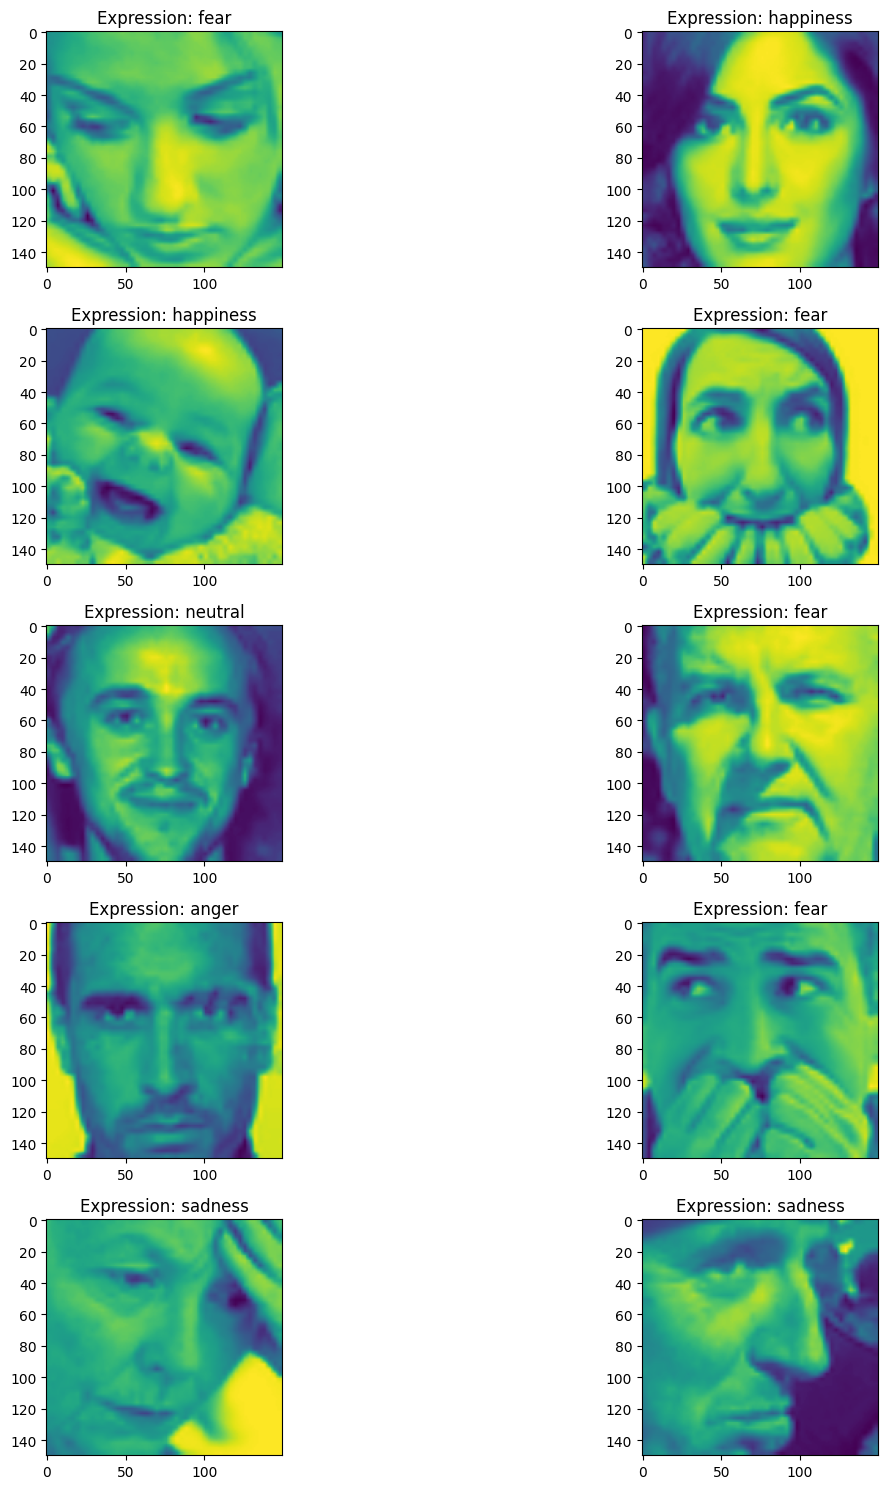

In [5]:
fig,ax=plt.subplots(5,2)
fig.set_size_inches(15,15)
for i in range(5):
    for j in range (2):
        l=rnd.randint(0,len(Z))
        ax[i,j].imshow(X[l])
        ax[i,j].set_title('Expression: '+Z[l])

plt.tight_layout()

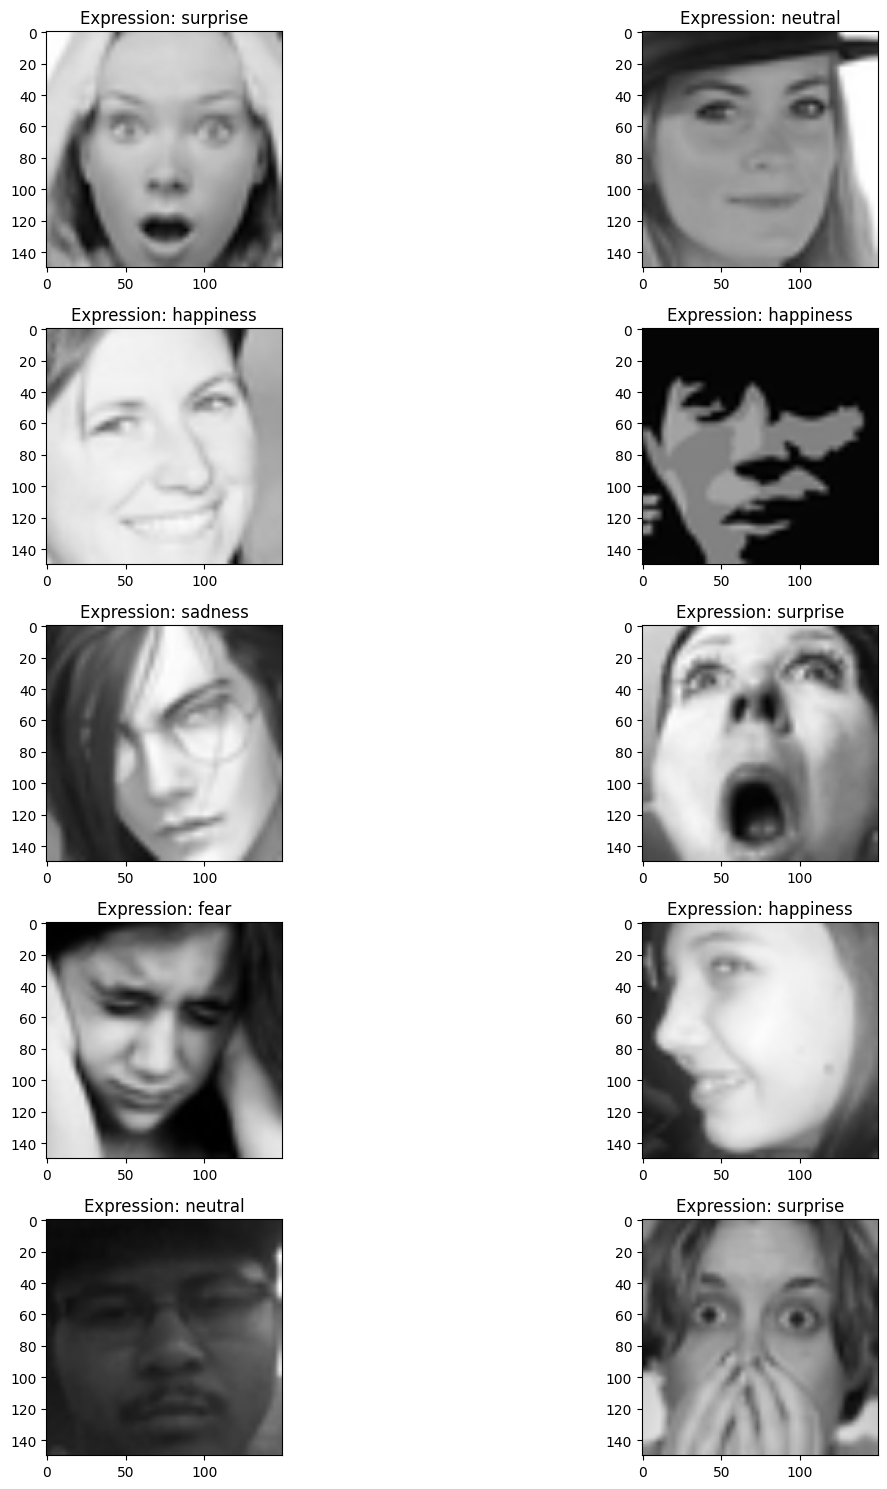

In [6]:
fig,ax=plt.subplots(5,2)
fig.set_size_inches(15,15)
for i in range(5):
    for j in range (2):
        l=rnd.randint(0,len(Z))
        ax[i,j].imshow(X_RGB[l])
        ax[i,j].set_title('Expression: '+Z[l])

plt.tight_layout()

## Procesamiento datasets

Se realiza el LabelEncoding, OneHotEncoding y normalización de las imagenes

In [7]:
le=LabelEncoder()
yi=le.fit_transform(Z) #Convierte a labels encoding
Y=to_categorical(yi,7) # convierte a one-hot encoding

In [8]:
X=np.array(X, dtype="float32") /255
X  = np.expand_dims(X, axis=-1)

In [9]:
X_RGB=np.array(X_RGB, dtype="float32") / 255

In [10]:
print(X.shape)        # esperado: (n, 150, 150, 1)
print(X_RGB.shape)    # esperado: (n, 150, 150, 3)
print(Y.shape)        # esperado: (n, 7)

(35887, 150, 150, 1)
(35887, 150, 150, 3)
(35887, 7)


Se separa el conjunto de datos

In [11]:
x_train, x_test, y_train, y_test = train_test_split(
    X, Y, test_size=0.25, random_state=42, stratify=yi
)

In [12]:
x_train_rgb, x_test_rgb, y_train_rgb, y_test_rgb = train_test_split(
    X_RGB, Y, test_size=0.25, random_state=42, stratify=yi
)

In [13]:
np.random.seed(42)
rnd.seed(42)
tf.random.set_seed(42)

# 4. Implementación CNN desde cero

In [14]:
# # modelling starts using a CNN.

model = Sequential()
model.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same',activation ='relu', input_shape = (IMG_SIZE,IMG_SIZE,1)))
model.add(MaxPooling2D(pool_size=(2,2)))


model.add(Conv2D(filters = 96, kernel_size = (3,3),padding = 'Same',activation ='relu'))
model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2)))


model.add(Conv2D(filters =128, kernel_size = (3,3),padding = 'Same',activation ='relu'))
model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2)))

model.add(Conv2D(filters = 128, kernel_size = (3,3),padding = 'Same',activation ='relu'))
model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2)))

model.add(Flatten())
model.add(Dense(512))
model.add(Activation('relu'))
model.add(Dense(7, activation = "softmax"))

d:\Repositorios\Personal\Reto_2_DeepLearning\.venv\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [15]:
model.compile(optimizer=Adam(),loss='categorical_crossentropy',metrics=['accuracy'])

In [16]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 150, 150, 32)   │           832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 75, 75, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 75, 75, 96)     │        27,744 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 37, 37, 96)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 37, 37, 128)    │       110,720 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 18, 18, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 18, 18, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 9, 9, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 10368)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │     5,308,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation (Activation)         │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 7)              │         3,591 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,599,399 (21.36 MB)

 Trainable params: 5,599,399 (21.36 MB)

 Non-trainable params: 0 (0.00 B)

In [17]:
History = model.fit(x_train,y_train, batch_size=64,
                              epochs = 10, validation_data = (x_test,y_test),
                              verbose = 1)

Epoch 1/10
421/421 ━━━━━━━━━━━━━━━━━━━━ 158s 374ms/step - accuracy: 0.3173 - loss: 1.6935 - val_accuracy: 0.3556 - val_loss: 1.6135
Epoch 2/10
421/421 ━━━━━━━━━━━━━━━━━━━━ 178s 423ms/step - accuracy: 0.4801 - loss: 1.3550 - val_accuracy: 0.5011 - val_loss: 1.3219
Epoch 3/10
421/421 ━━━━━━━━━━━━━━━━━━━━ 202s 480ms/step - accuracy: 0.5644 - loss: 1.1557 - val_accuracy: 0.5220 - val_loss: 1.3099
Epoch 4/10
421/421 ━━━━━━━━━━━━━━━━━━━━ 203s 483ms/step - accuracy: 0.6351 - loss: 0.9793 - val_accuracy: 0.5272 - val_loss: 1.3174
Epoch 5/10
421/421 ━━━━━━━━━━━━━━━━━━━━ 205s 487ms/step - accuracy: 0.7206 - loss: 0.7652 - val_accuracy: 0.5055 - val_loss: 1.7946
Epoch 6/10
421/421 ━━━━━━━━━━━━━━━━━━━━ 204s 486ms/step - accuracy: 0.7975 - loss: 0.5626 - val_accuracy: 0.5115 - val_loss: 2.1664
Epoch 7/10
421/421 ━━━━━━━━━━━━━━━━━━━━ 204s 485ms/step - accuracy: 0.8512 - loss: 0.4185 - val_accuracy: 0.5312 - val_loss: 2.3748
Epoch 8/10
421/421 ━━━━━━━━━━━━━━━━━━━━ 204s 485ms/step - accuracy: 0.8904 -

In [18]:
pred=model.predict(x_test)
pred_digits=np.argmax(pred,axis=1)

281/281 ━━━━━━━━━━━━━━━━━━━━ 15s 52ms/step


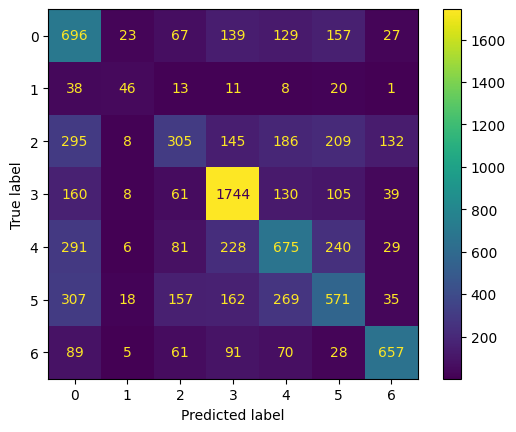

In [22]:
cm_CNN_desde_cero = ConfusionMatrixDisplay(confusion_matrix(np.argmax(y_test,axis=1),pred_digits))
cm_CNN_desde_cero.plot()
plt.show()

In [23]:
print(classification_report(np.argmax(y_test,axis=1),pred_digits, target_names=EXPRESSIONS))

              precision    recall  f1-score   support

       anger       0.37      0.56      0.45      1238
     disgust       0.40      0.34      0.37       137
        fear       0.41      0.24      0.30      1280
   happiness       0.69      0.78      0.73      2247
     neutral       0.46      0.44      0.45      1550
     sadness       0.43      0.38      0.40      1519
    surprise       0.71      0.66      0.68      1001

    accuracy                           0.52      8972
   macro avg       0.50      0.48      0.48      8972
weighted avg       0.52      0.52      0.51      8972



In [24]:
# now storing some properly as well as misclassified indexes'.
i=0
prop_class=[]
mis_class=[]

for i in range(len(y_test)):
    if(np.argmax(y_test[i])==pred_digits[i]):
        prop_class.append(i)
    if(len(prop_class)==8):
        break

i=0
for i in range(len(y_test)):
    if(not np.argmax(y_test[i])==pred_digits[i]):
        mis_class.append(i)
    if(len(mis_class)==8):
        break

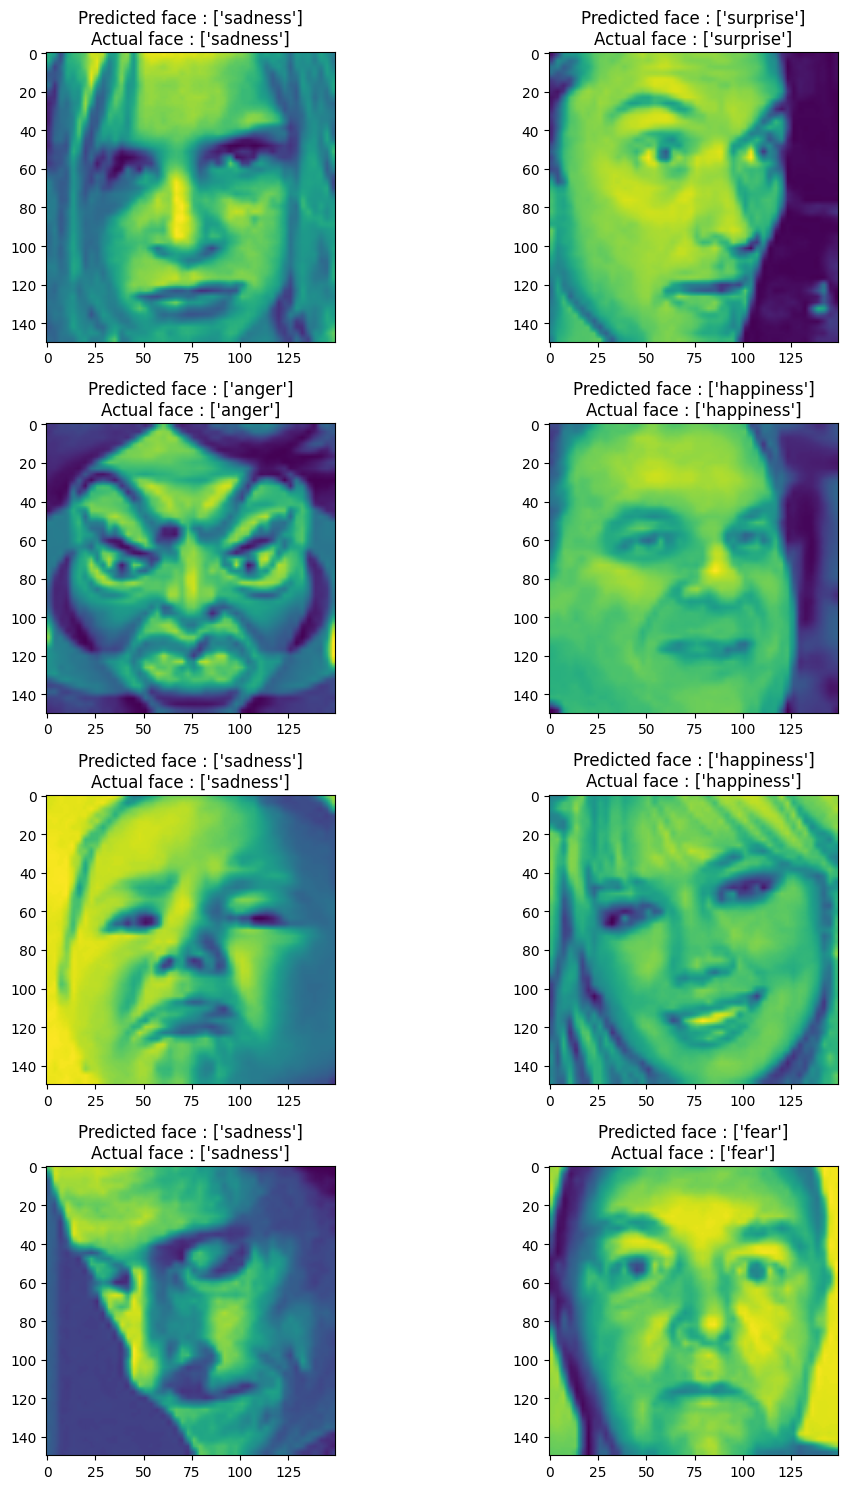

In [25]:
warnings.filterwarnings('always')
warnings.filterwarnings('ignore')

count=0
fig,ax=plt.subplots(4,2)
fig.set_size_inches(15,15)
for i in range (4):
    for j in range (2):
        ax[i,j].imshow(x_test[prop_class[count]])
        predict_max=np.argmax(y_test,axis=1)
        ax[i,j].set_title("Predicted face : "+str(le.inverse_transform([pred_digits[prop_class[count]]]))+"\n"+"Actual face : "+str(le.inverse_transform([predict_max[prop_class[count]]])))
        plt.tight_layout()
        count+=1

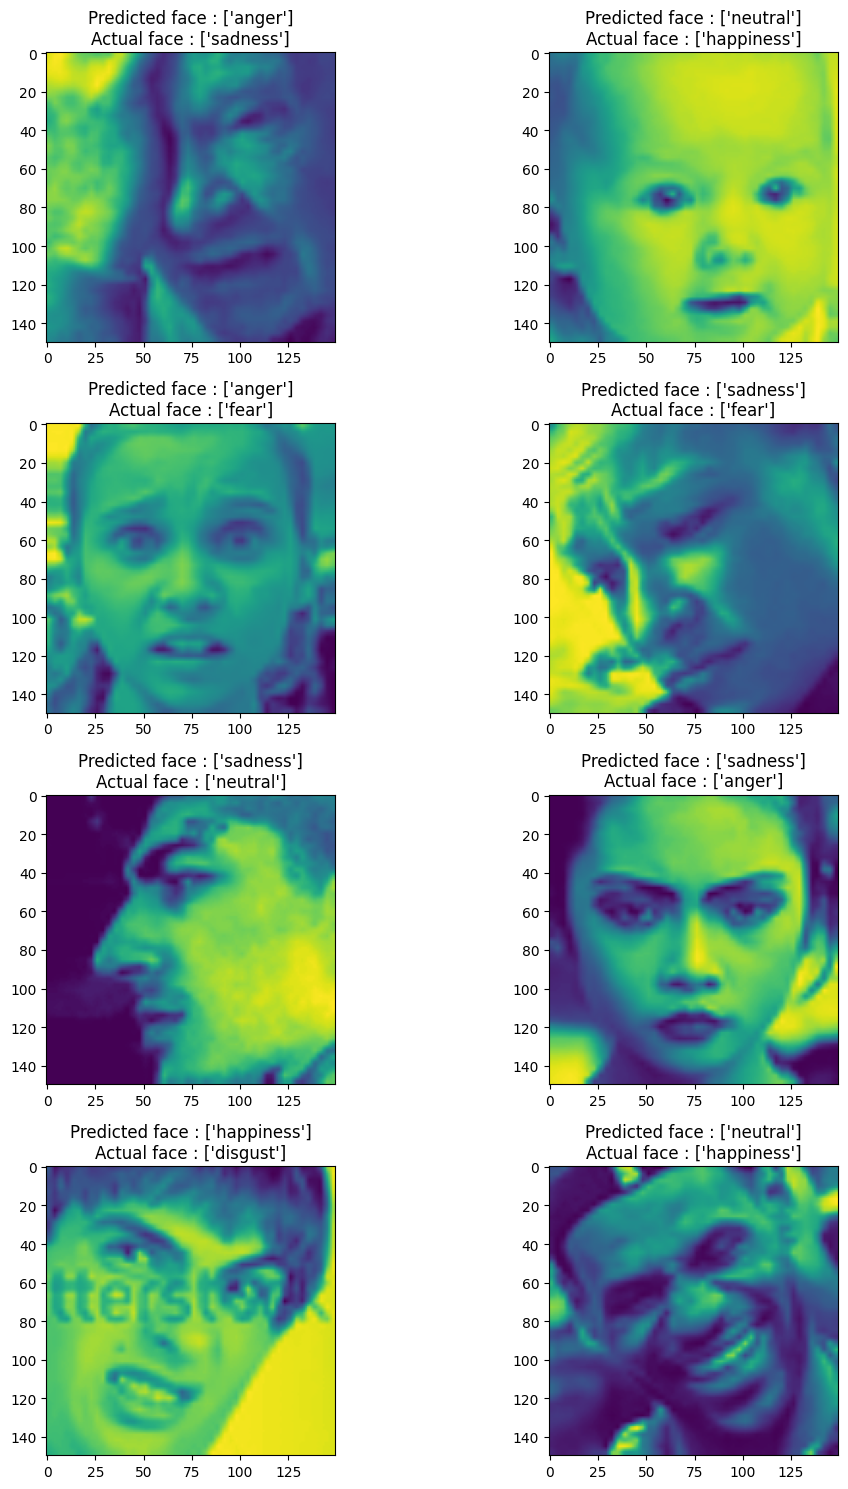

In [26]:
#warnings.filterwarnings('always')
#warnings.filterwarnings('ignore')

count=0
fig,ax=plt.subplots(4,2)
fig.set_size_inches(15,15)
for i in range (4):
    for j in range (2):
        ax[i,j].imshow(x_test[mis_class[count]])
        predict_max=np.argmax(y_test,axis=1)
        ax[i,j].set_title("Predicted face : "+str(le.inverse_transform([pred_digits[mis_class[count]]]))+"\n"+"Actual face : "+str(le.inverse_transform([predict_max[mis_class[count]]])))
        plt.tight_layout()
        count+=1

In [ ]:
#impiar memoria antes del Fine-Tune
#import gc
#from keras import backend as K

#K.clear_session()  # libera el grafo de la CNN en gris
# liberar tensores de la fase 1 (gris)
#del x_train, x_test, y_train, y_test, X
#gc.collect()


0

# Transfer Learning y Fine Tunning

### *Vamos a utilizar el modelo preentrenado Restnet*

In [27]:
from keras.applications.vgg16 import VGG16
from keras.applications.vgg16 import preprocess_input

from keras.applications.resnet import ResNet50
from keras.applications.mobilenet_v2 import MobileNetV2


In [31]:
model_FT = Sequential()

#model_FT.add(MobileNetV2(include_top=False, pooling='avg', weights='imagenet'))
model_FT.add(VGG16(include_top=False, pooling='avg', weights='imagenet'))
model_FT.add(Flatten())
model_FT.add(BatchNormalization())
model_FT.add(Dense(512, activation='relu'))
model_FT.add(Dropout(0.3))
model_FT.add(BatchNormalization())
model_FT.add(Dense(256, activation='relu'))
model_FT.add(Dropout(0.2))
model_FT.add(BatchNormalization())
model_FT.add(Dense(7, activation='softmax'))

model_FT.layers[0].trainable = False

In [32]:
from keras.optimizers import Adam
model_FT.compile(optimizer=Adam(),loss='categorical_crossentropy',metrics=['accuracy'])
model_FT.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ vgg16 (Functional)              │ (None, 512)            │    14,714,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 512)            │       262,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 7)              │         1,799 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 15,115,591 (57.66 MB)

 Trainable params: 398,343 (1.52 MB)

 Non-trainable params: 14,717,248 (56.14 MB)

In [33]:
History = model_FT.fit(x_train_rgb, y_train_rgb,
                        batch_size=64,
                        epochs=10,
                        validation_data=(x_test_rgb, y_test_rgb),
                        verbose=1)

Epoch 1/10
421/421 ━━━━━━━━━━━━━━━━━━━━ 1108s 3s/step - accuracy: 0.3975 - loss: 1.6714 - val_accuracy: 0.4466 - val_loss: 1.4373
Epoch 2/10
421/421 ━━━━━━━━━━━━━━━━━━━━ 1140s 3s/step - accuracy: 0.4699 - loss: 1.3961 - val_accuracy: 0.4806 - val_loss: 1.3635
Epoch 3/10
421/421 ━━━━━━━━━━━━━━━━━━━━ 1141s 3s/step - accuracy: 0.5021 - loss: 1.3145 - val_accuracy: 0.4889 - val_loss: 1.3526
Epoch 4/10
421/421 ━━━━━━━━━━━━━━━━━━━━ 1091s 3s/step - accuracy: 0.5277 - loss: 1.2498 - val_accuracy: 0.5010 - val_loss: 1.3425
Epoch 5/10
421/421 ━━━━━━━━━━━━━━━━━━━━ 1109s 3s/step - accuracy: 0.5483 - loss: 1.1976 - val_accuracy: 0.5038 - val_loss: 1.3392
Epoch 6/10
421/421 ━━━━━━━━━━━━━━━━━━━━ 1122s 3s/step - accuracy: 0.5732 - loss: 1.1369 - val_accuracy: 0.5070 - val_loss: 1.3398
Epoch 7/10
421/421 ━━━━━━━━━━━━━━━━━━━━ 1130s 3s/step - accuracy: 0.5971 - loss: 1.0851 - val_accuracy: 0.5125 - val_loss: 1.3497
Epoch 8/10
421/421 ━━━━━━━━━━━━━━━━━━━━ 1132s 3s/step - accuracy: 0.6121 - loss: 1.0367 - 

In [34]:
# getting predictions on val set.
pred_FT=model_FT.predict(x_test_rgb)
pred_digits_FT=np.argmax(pred_FT,axis=1)

281/281 ━━━━━━━━━━━━━━━━━━━━ 278s 990ms/step


In [35]:
accuracy_score(np.argmax(y_test_rgb,axis=1),pred_digits_FT)

0.5287561301827909

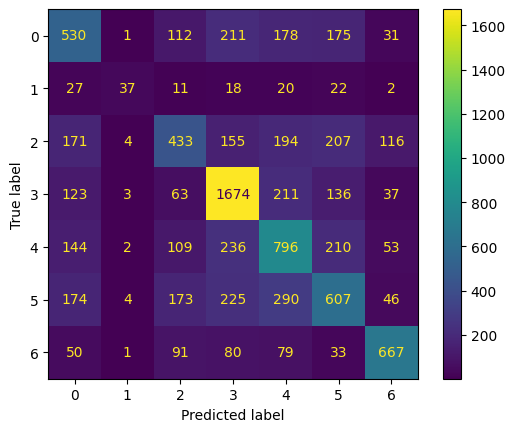

In [36]:
ConfusionMatrixDisplay(confusion_matrix(np.argmax(y_test_rgb,axis=1),pred_digits_FT)).plot()

plt.show()

In [37]:
target_names = ['anger', 'disgust', 'fear', 'happiness', 'neutral', 'sadness', 'surprise']
print(classification_report(np.argmax(y_test_rgb,axis=1), pred_digits, target_names=EXPRESSIONS))

              precision    recall  f1-score   support

       anger       0.37      0.56      0.45      1238
     disgust       0.40      0.34      0.37       137
        fear       0.41      0.24      0.30      1280
   happiness       0.69      0.78      0.73      2247
     neutral       0.46      0.44      0.45      1550
     sadness       0.43      0.38      0.40      1519
    surprise       0.71      0.66      0.68      1001

    accuracy                           0.52      8972
   macro avg       0.50      0.48      0.48      8972
weighted avg       0.52      0.52      0.51      8972



In [38]:
# now storing some properly as well as misclassified indexes'.
i=0
prop_class=[]
mis_class=[]

for i in range(len(y_test_rgb)):
    if(np.argmax(y_test_rgb[i])==pred_digits_FT[i]):
        prop_class.append(i)
    if(len(prop_class)==8):
        break

i=0
for i in range(len(y_test_rgb)):
    if(not np.argmax(y_test_rgb[i])==pred_digits_FT[i]):
        mis_class.append(i)
    if(len(mis_class)==8):
        break

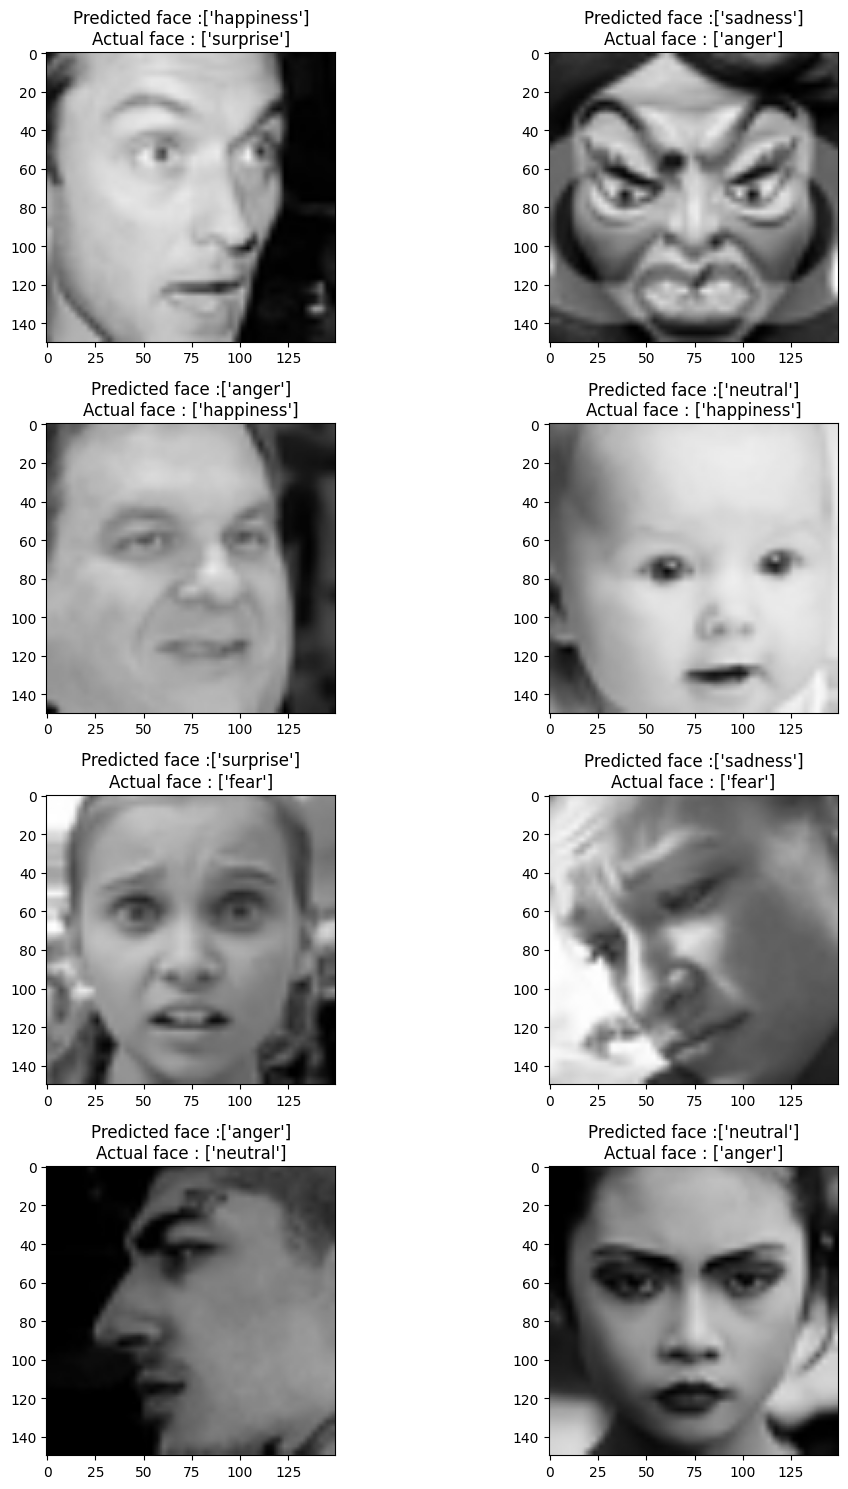

In [39]:
import warnings
warnings.filterwarnings('always')
warnings.filterwarnings('ignore')

count=0
fig,ax=plt.subplots(4,2)
fig.set_size_inches(15,15)
for i in range (4):
    for j in range (2):
        ax[i,j].imshow(x_test_rgb[mis_class[count]])
        ax[i,j].set_title("Predicted face :"+str(le.inverse_transform([pred_digits_FT[mis_class[count]]]))+"\n"+"Actual face : "+str(le.inverse_transform([np.argmax(y_test_rgb[mis_class[count]])])))
        plt.tight_layout()
        count+=1